# Smoothness
---
The purpose of this notebook is to compute the smoothness of several model parameterization outputs w.r.t. some generated teacher outputs.

## Notebook configuration
Configure several notebook configuration settings.

In [1]:
# Disable some warnings

import warnings

warnings.filterwarnings('ignore')
# warnings.filterwarnings('ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore', category=UserWarning)
# warnings.filterwarnings('ignore', category=FutureWarning)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# Use full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

Disable autoscrolling for better visualization of results:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Libraries / Packages
Import several useful packages for the notebook and configure some extra options.

In [3]:
# Miscellaneous libraries
import os
import time
import random
import itertools
import numpy as np
import pandas as pd
import networkx as nx

from tqdm.notebook import tqdm
from collections import defaultdict, Counter

# Setup some options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100


# Visualization
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

## Utility functions
---
Define some utility functions that will be used later for fetching data and ploting.

In [4]:
# Define some auxiliary functions for reading the generated smoothness csv files
def readSmoothnessCSV(smoothness_filename, reset_index=True):
    '''Auxiliary function to read a generated smoothness csv file.'''
    smoothness_stats = pd.read_csv(smoothness_filename, header=[0, 1, 2], index_col=[0, 1])
    if reset_index:
        smoothness_stats = smoothness_stats.reset_index().rename(columns={'level_0': 'model', 'level_1': 'model_config'})
    return smoothness_stats



In [15]:
def getAllStats(smoothness_stats_avg, setting='train'):
    '''Auxiliary function that retrieves all the separated data for each of the observable columns.'''
    smoothness_stats_avg_setting = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(1) == setting]
    smoothness_stats_avg_setting.columns = smoothness_stats_avg_setting.columns.droplevel(1)
    all_stats = {}
    data_cols = [col for col in smoothness_stats_avg_setting.columns.get_level_values(1).unique() if col]
    for data_col in data_cols:
        all_stats[data_col] = smoothness_stats_avg_setting.iloc[:, smoothness_stats_avg_setting.columns.get_level_values(1) == data_col]
        all_stats[data_col].columns = all_stats[data_col].columns.droplevel(1)
    return all_stats


def plotDynamicsSmoothnessRMSE(ax, idx1, idx2, all_stats, model_config, 
                               color=None, marker=None, setting='train', smoothness_ylim=None, rmse_ylim=None):
    '''Auxiliary function that plots the smoothness and RMSE dynamics during training for a given setting.'''
    # Retrieve Y-axis variables
    mean_smoothness = all_stats['mean_smoothness'].loc[model_config].to_numpy()
    std_dev_smoothness = all_stats['std_dev_smoothness'].loc[model_config].to_numpy()
    mean_rmse = all_stats['mean_rmse'].loc[model_config].to_numpy()
    std_dev_rmse = all_stats['std_dev_rmse'].loc[model_config].to_numpy()
    # X-axis
    n = len(mean_smoothness)
    x = np.arange(n)
    if model_config[0] == 'Real':
        # Plot the 'constant' smoothness and rmse
        ax[idx1].axhline(
            y=mean_smoothness[0], color='orange', alpha=1, ls='-.', label='Real')
    elif model_config[0] == 'Baseline':
        # Plot the 'constant' smoothness and rmse
        ax[idx1].axhline(
            y=mean_smoothness[0], color=color, marker=marker, markevery=5, alpha=0.75, markersize=16,
            label=f"{model_config[0]} ({model_config[1].split('__')[-1]})")
        ax[idx2].axhline(
            y=mean_rmse[0], color=color, marker=marker, markevery=5, alpha=0.75, markersize=16,
            label=f"{model_config[0]} ({model_config[1].split('__')[-1]})")
    else:
        # Plot the mean and standard deviation of the smoothness
        ax[idx1].plot(
            x, mean_smoothness, color=color, marker=marker, markevery=5, alpha=0.75, markersize=16,
            label=f"{model_config[0]} ({model_config[1].split('__init')[0]})")
        # Plot the mean and standard deviation of the smoothness
        ax[idx2].plot(
            x, mean_rmse, color=color, marker=marker, markevery=5, alpha=0.75, markersize=16,
            label=f"{model_config[0]} ({model_config[1].split('__init')[0]})")
    # Fix ticks and limit ranges
    if smoothness_ylim is not None:
        ax[idx1].set_ylim(bottom=-0.005, top=smoothness_ylim)
    ax[idx1].set_xlim(left=x[0], right=x[-1])
    ax[idx2].set_xlim(left=x[0], right=x[-1])
    if len(x) <= 50:
        ax[idx1].set_xticks(x)
        ax[idx2].set_xticks(x)
    else:
        ax[idx1].set_xticks(np.arange(0, x[-1] + 1, 5))
        ax[idx2].set_xticks(np.arange(0, x[-1] + 1, 5))
    if rmse_ylim is not None:
        ax[idx2].set_ylim(bottom=0, top=rmse_ylim)
    else:
        ax[idx2].set_ylim(bottom=0, top=1)
    # Add title and axis labels
    ax[idx1].set_title(f'Smoothness dynamics during {setting}', fontsize=26)
    ax[idx1].set_xlabel('Epochs', fontsize=18)
    ax[idx1].set_ylabel('Smoothness', fontsize=18)
    ax[idx2].set_xlabel('Epochs', fontsize=18)
    ax[idx2].set_title(f'RMSE dynamics during {setting}', fontsize=26)
    ax[idx2].set_ylabel('RMSE', fontsize=18)
    # Visualize legend
    ax[idx2].legend(bbox_to_anchor=(1.05, 1), prop={'size': 18})
    # ax[idx1].legend()

    
def plotScatterSmoothnessRMSE(model_configs_final_dict):
    '''Auxiliary function to plot a scatter plot of smoothness vs RMSE (train/test/extrapolation).'''
    # Define color maps and markers for the models
    cmaps = 'bgrcmyk'
    markers = 'oxdP'
    # Init the figure
    fig, ax = plt.subplots(1, 3, figsize=(36, 12))
    # Train / test /extrapolation
    for i, (model, configs) in enumerate(model_configs_final_dict.items()):
        color = cmaps[i]
        j = 0
        for config in configs: 
            model_config = (model, config)
            if ((config.endswith('initDefault_') or ###
                (config.startswith('__'.join(DIST_MATRIX.split('__')[:-2])))) or
                (model == 'Real')):
                marker = markers[j]
                j += 1
                for k, setting in enumerate(['train', 'test', 'extrapolation']):
                    y = smoothness_stats_avg_final.loc[model_config][(setting, 'mean_rmse')]
                    x = smoothness_stats_avg_final.loc[model_config][(setting, 'mean_smoothness')]
                    # Real values
                    if model_config[0] == 'Real':
                        ax[k].axvline(x=x, color='orange', alpha=1, ls='-.', label='Real')
                    else:
                        if model_config[0] != 'Baseline':
                            c = f"{model_config[0]} ({model_config[1].split('__init')[0]})"
                        else:
                            c = f"{model_config[0]} ({model_config[1].split('__')[-1]})"
                        ax[k].scatter(x, y, s=160, label=c, color=color, marker=marker)
                    ax[k].set_title(setting.capitalize(), fontsize=18)
                    ax[k].set_xlabel('Avg. smoothness', fontsize=12)
                    ax[k].set_ylabel('Avg. RMSE', fontsize=12)
                    ax[k].legend(loc=7)
    fig.suptitle("Avg. RMSE vs Avg. smoothness (train/test/extrapolation)", fontsize=24)
    plt.show()

### Fetching data to analyze
---
Fetch all the generated `smoothness` csv files generated and analyze them.

In [6]:
!ls "../../data/synthetic/erdos_renyi"

N100_n100_p0.1_1625733973 N100_n100_p0.1_1626337521 N100_n100_p0.1_1626568198
N100_n100_p0.1_1626119054 N100_n100_p0.1_1626346711 N110_n100_p0.1_1626075392
N100_n100_p0.1_1626164138 N100_n100_p0.1_1626430237 dropoff
N100_n100_p0.1_1626187776 N100_n100_p0.1_1626447811 extrapolation_comparison


In [7]:
TEACHER_OUTPUTS_PREFIX = '../../data/synthetic/erdos_renyi/N100_n100_p0.1_1626568198/teacher_outputs/regression/GIN'
TEACHER_CONFIG = 'hidden32_blocks3_residual0_jkFalse_preFalse__initUniform_bias0.0_lower-0.1_upper0.1'
DIST_MATRIX = 'WL__hashing__d3_iOnes__dist_matrices__hamming__sMaxdegree__train__full64'

teacher_outputs_filenames = [
    x for x in os.listdir(f"{TEACHER_OUTPUTS_PREFIX}/{TEACHER_CONFIG}")
    if all([c.isdigit() for c in x])
]

# Gather all results for a given fixed teacher parameterization and a fixed distance matrix for computing the smoothness
smoothness_stats = pd.DataFrame()
for teacher_outputs_filename in teacher_outputs_filenames:
    student_outputs_filename = \
        f"{TEACHER_OUTPUTS_PREFIX}/{TEACHER_CONFIG}/{teacher_outputs_filename}/smoothness/{DIST_MATRIX}.csv"
    smoothness_stats = smoothness_stats.append(
        readSmoothnessCSV(student_outputs_filename, reset_index=False), ignore_index=False)

# Convert arrays & weird things to floats
smoothness_stats = smoothness_stats.applymap(
    lambda x: x[0] if isinstance(x, list) else x if isinstance(x, float) else float(x.strip('[ ]')))

# Reset index
smoothness_stats = smoothness_stats.reset_index().rename(columns={'level_0': 'model', 'level_1': 'model_config'})

# Average the results throughout the different teacher initializations.
smoothness_stats_avg = smoothness_stats.groupby(['model', 'model_config']).mean()


Visualizing smoothness with the following configuration:

    • Teacher configuration used: GIN (hidden32_blocks3_residual0_jkFalse_preFalse__initUniform_bias0.0_lower-0.1_upper0.1).
    • All student networks were initialized with the same parameters.
    • Distance matrix used: WL__hashing__d3_iOnes__dist_matrices__hamming__sMaxdegree__train__full64.





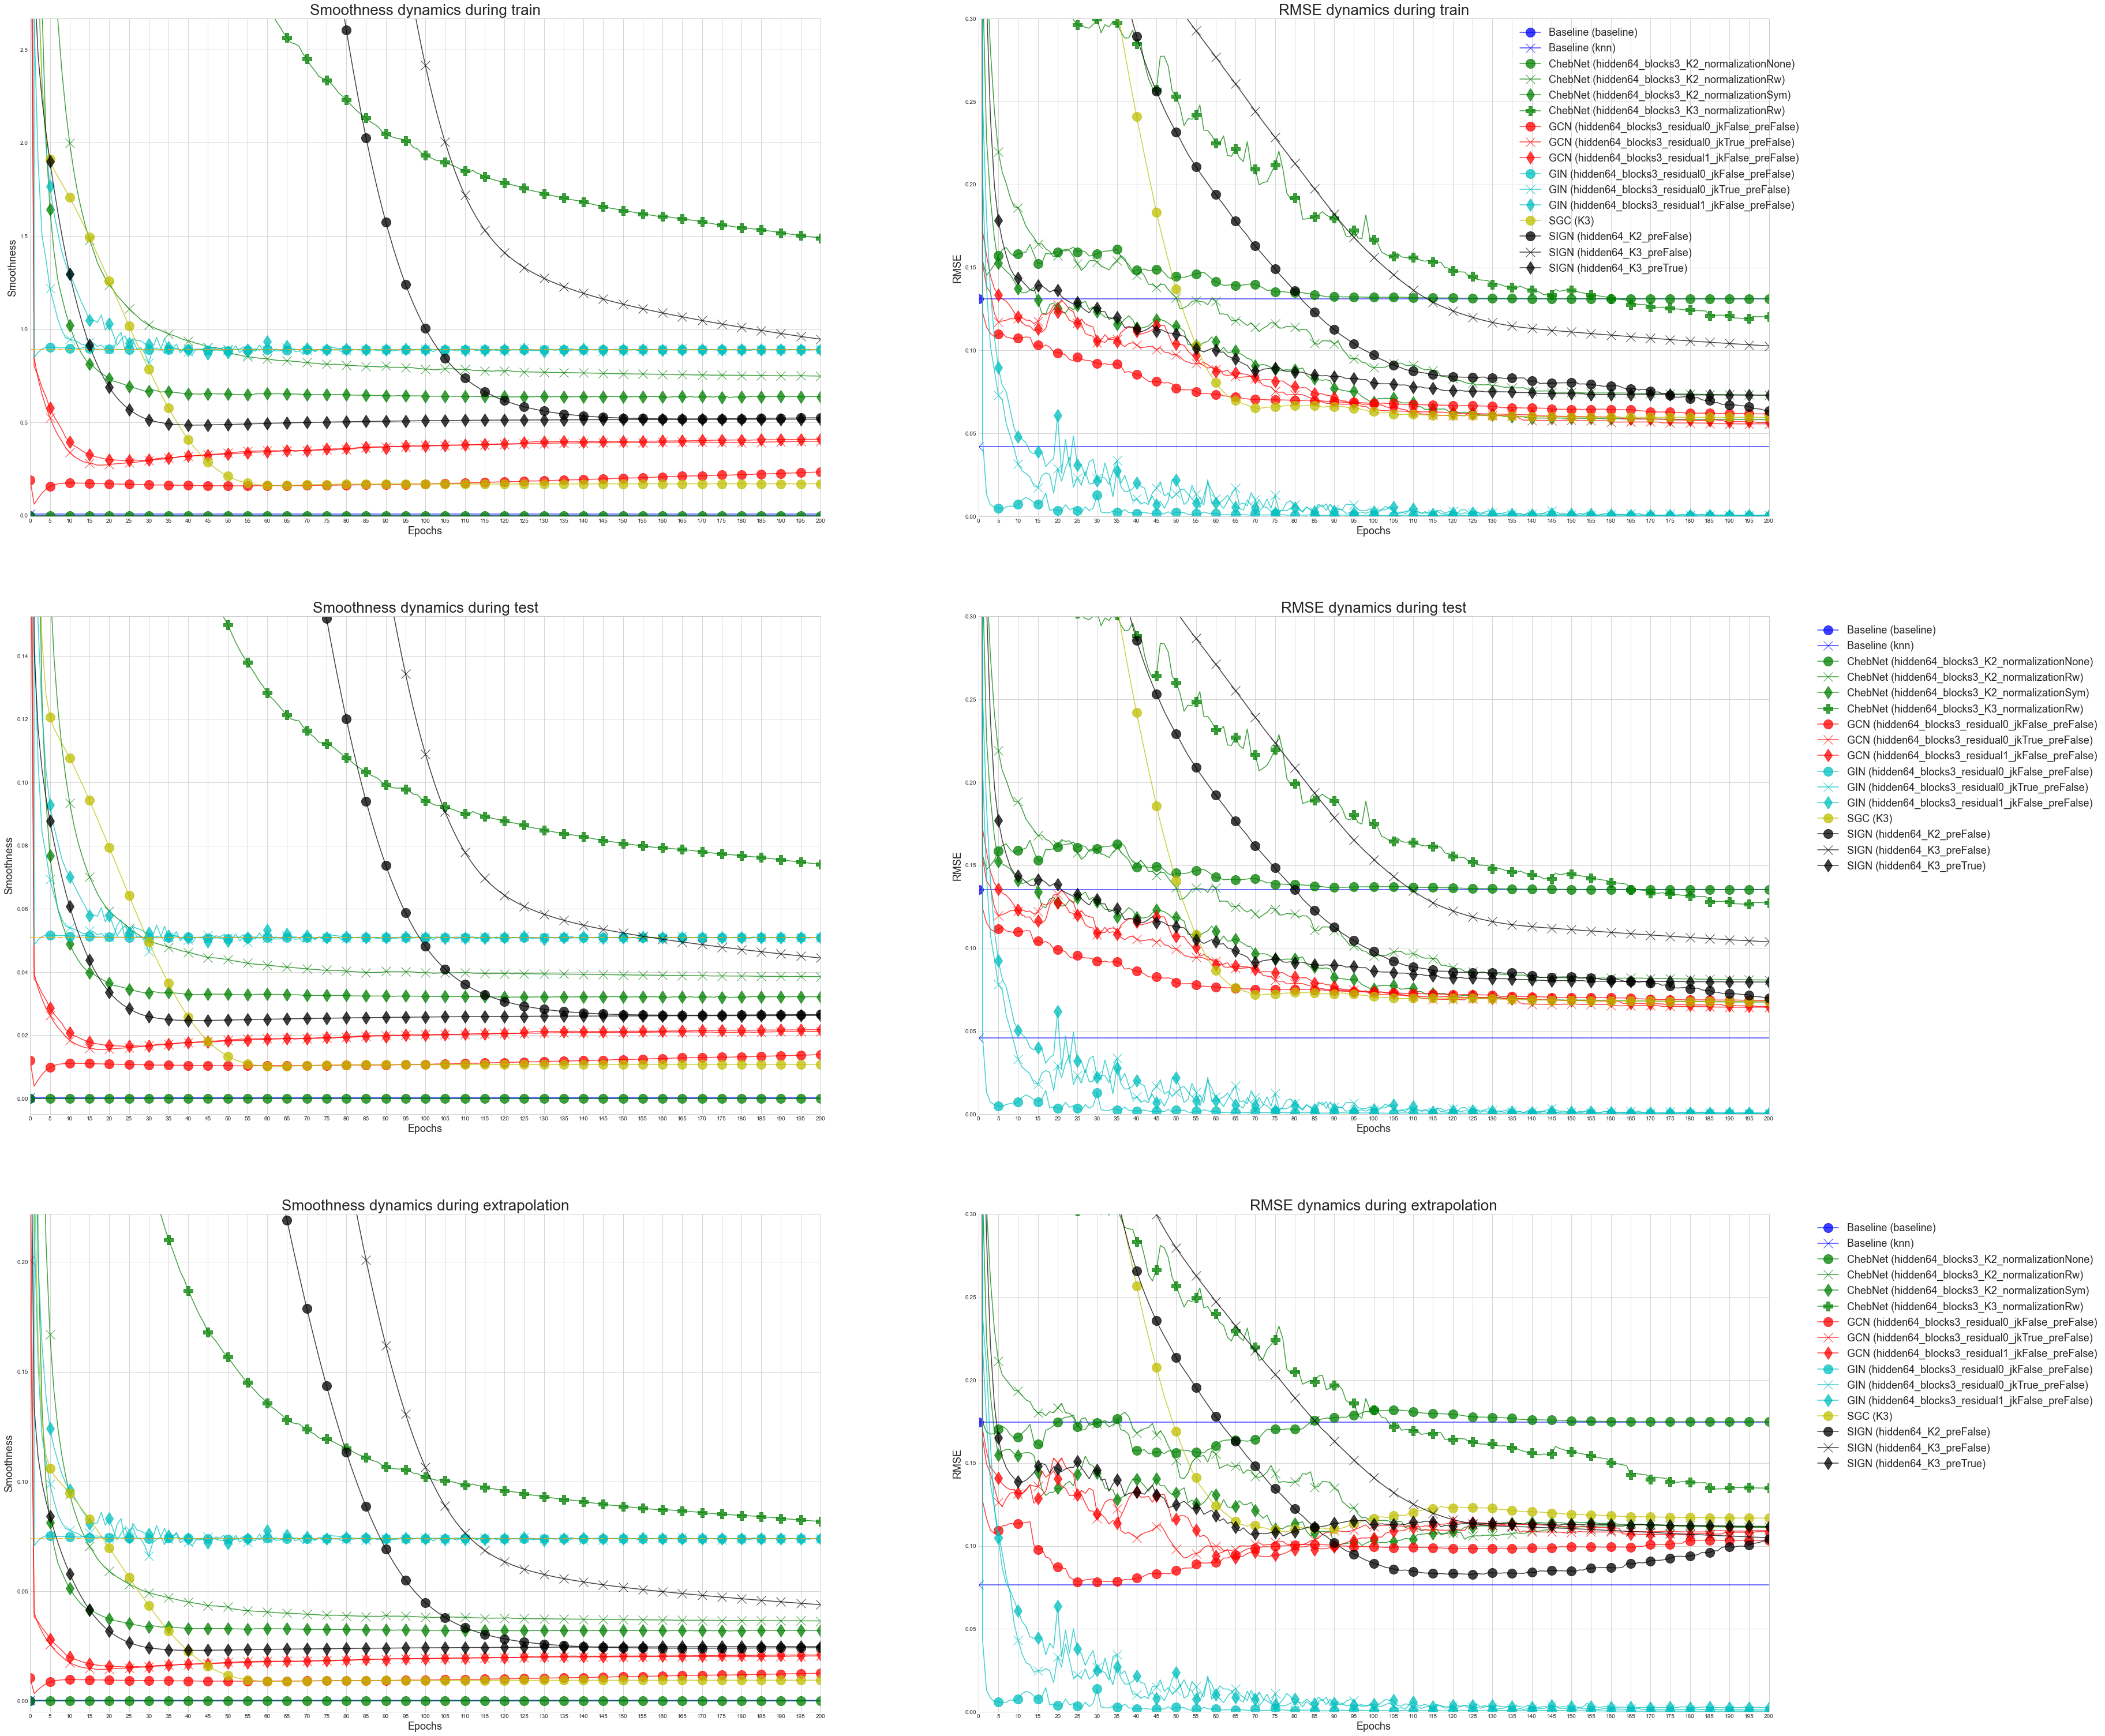

In [16]:

# Retrieve all the column-split data
all_stats_train = getAllStats(smoothness_stats_avg, setting='train')
all_stats_test = getAllStats(smoothness_stats_avg, setting='test')
all_stats_extrapolation = getAllStats(smoothness_stats_avg, setting='extrapolation')
# Retrieve all model parameterizations
model_configs = smoothness_stats_avg.index.tolist()
model_configs_dict = defaultdict(list)
for model_config in model_configs:
    model_configs_dict[model_config[0]].append(model_config[1])
# Define color maps and markers for the models
cmaps = 'bgrcmyk'
markers = 'oxdP1234'

SMOOTHNESS_YLIM_TRAIN=None
SMOOTHNESS_YLIM_TEST=None
SMOOTHNESS_YLIM_EXTRAPOLATION=None
RMSE_YLIM=0.3

# Create the figure and plot everything
fig, ax = plt.subplots(3, 2, figsize=(54, 54))
ax = ax.flatten()

# Train / test /extrapolation
for i, (model, configs) in enumerate(model_configs_dict.items()):
    color = cmaps[i]
    j = 0
    for config in configs: 
        model_config = (model, config)
        # Real signal
        if config == ' ':
            real_smoothness_train = all_stats_train['mean_smoothness'].loc[model_config].to_numpy()[0]
            SMOOTHNESS_YLIM_TRAIN =  3 * real_smoothness_train
            plotDynamicsSmoothnessRMSE(
                ax, 0, 1, all_stats_train, model_config, 
                setting='train', smoothness_ylim=SMOOTHNESS_YLIM_TRAIN, rmse_ylim=RMSE_YLIM)
            real_smoothness_test = all_stats_test['mean_smoothness'].loc[model_config].to_numpy()[0]
            SMOOTHNESS_YLIM_TEST =  3 * real_smoothness_test
            plotDynamicsSmoothnessRMSE(
                ax, 2, 3, all_stats_test, model_config,
                setting='test', smoothness_ylim=SMOOTHNESS_YLIM_TEST, rmse_ylim=RMSE_YLIM)
            real_smoothness_extrapolation = all_stats_extrapolation['mean_smoothness'].loc[model_config].to_numpy()[0]
            SMOOTHNESS_YLIM_EXTRAPOLATION =  3 * real_smoothness_extrapolation
            plotDynamicsSmoothnessRMSE(
                ax, 4, 5, all_stats_extrapolation, model_config,
                setting='extrapolation', smoothness_ylim=SMOOTHNESS_YLIM_EXTRAPOLATION, rmse_ylim=RMSE_YLIM)
        # Baselines & GNNs
        elif ((config.endswith(TEACHER_CONFIG.split('__')[-1])) or
              (config.startswith('__'.join(DIST_MATRIX.split('__')[:-2])))):
            marker = markers[j]
            j += 1
            plotDynamicsSmoothnessRMSE(
                ax, 0, 1, all_stats_train, model_config, color=color, 
                marker=marker, setting='train', smoothness_ylim=SMOOTHNESS_YLIM_TRAIN, rmse_ylim=RMSE_YLIM)
            plotDynamicsSmoothnessRMSE(
                ax, 2, 3, all_stats_test, model_config, color=color, 
                marker=marker, setting='test', smoothness_ylim=SMOOTHNESS_YLIM_TEST, rmse_ylim=RMSE_YLIM)
            plotDynamicsSmoothnessRMSE(
                ax, 4, 5, all_stats_extrapolation, model_config, color=color, 
                marker=marker, setting='extrapolation', smoothness_ylim=SMOOTHNESS_YLIM_EXTRAPOLATION, rmse_ylim=RMSE_YLIM)
        
# Print some context of the output results        
print_info = f"""
Visualizing smoothness with the following configuration:

    \u2022 Teacher configuration used: \033[4mGIN ({TEACHER_CONFIG})\033[0m.
    \u2022 All student networks were initialized with the same parameters.
    \u2022 Distance matrix used: \033[4m{DIST_MATRIX}\033[0m.


"""
print(print_info)
plt.show()


Visualizing smoothness with the following configuration:

    • Teacher configuration used: GIN (hidden32_blocks3_residual0_jkFalse_preFalse__initUniform_bias0.0_lower-0.1_upper0.1).
    • All student networks were initialized with the same parameters.
    • Distance matrix used: WL__hashing__d3_iOnes__dist_matrices__hamming__sMaxdegree__train__full64.





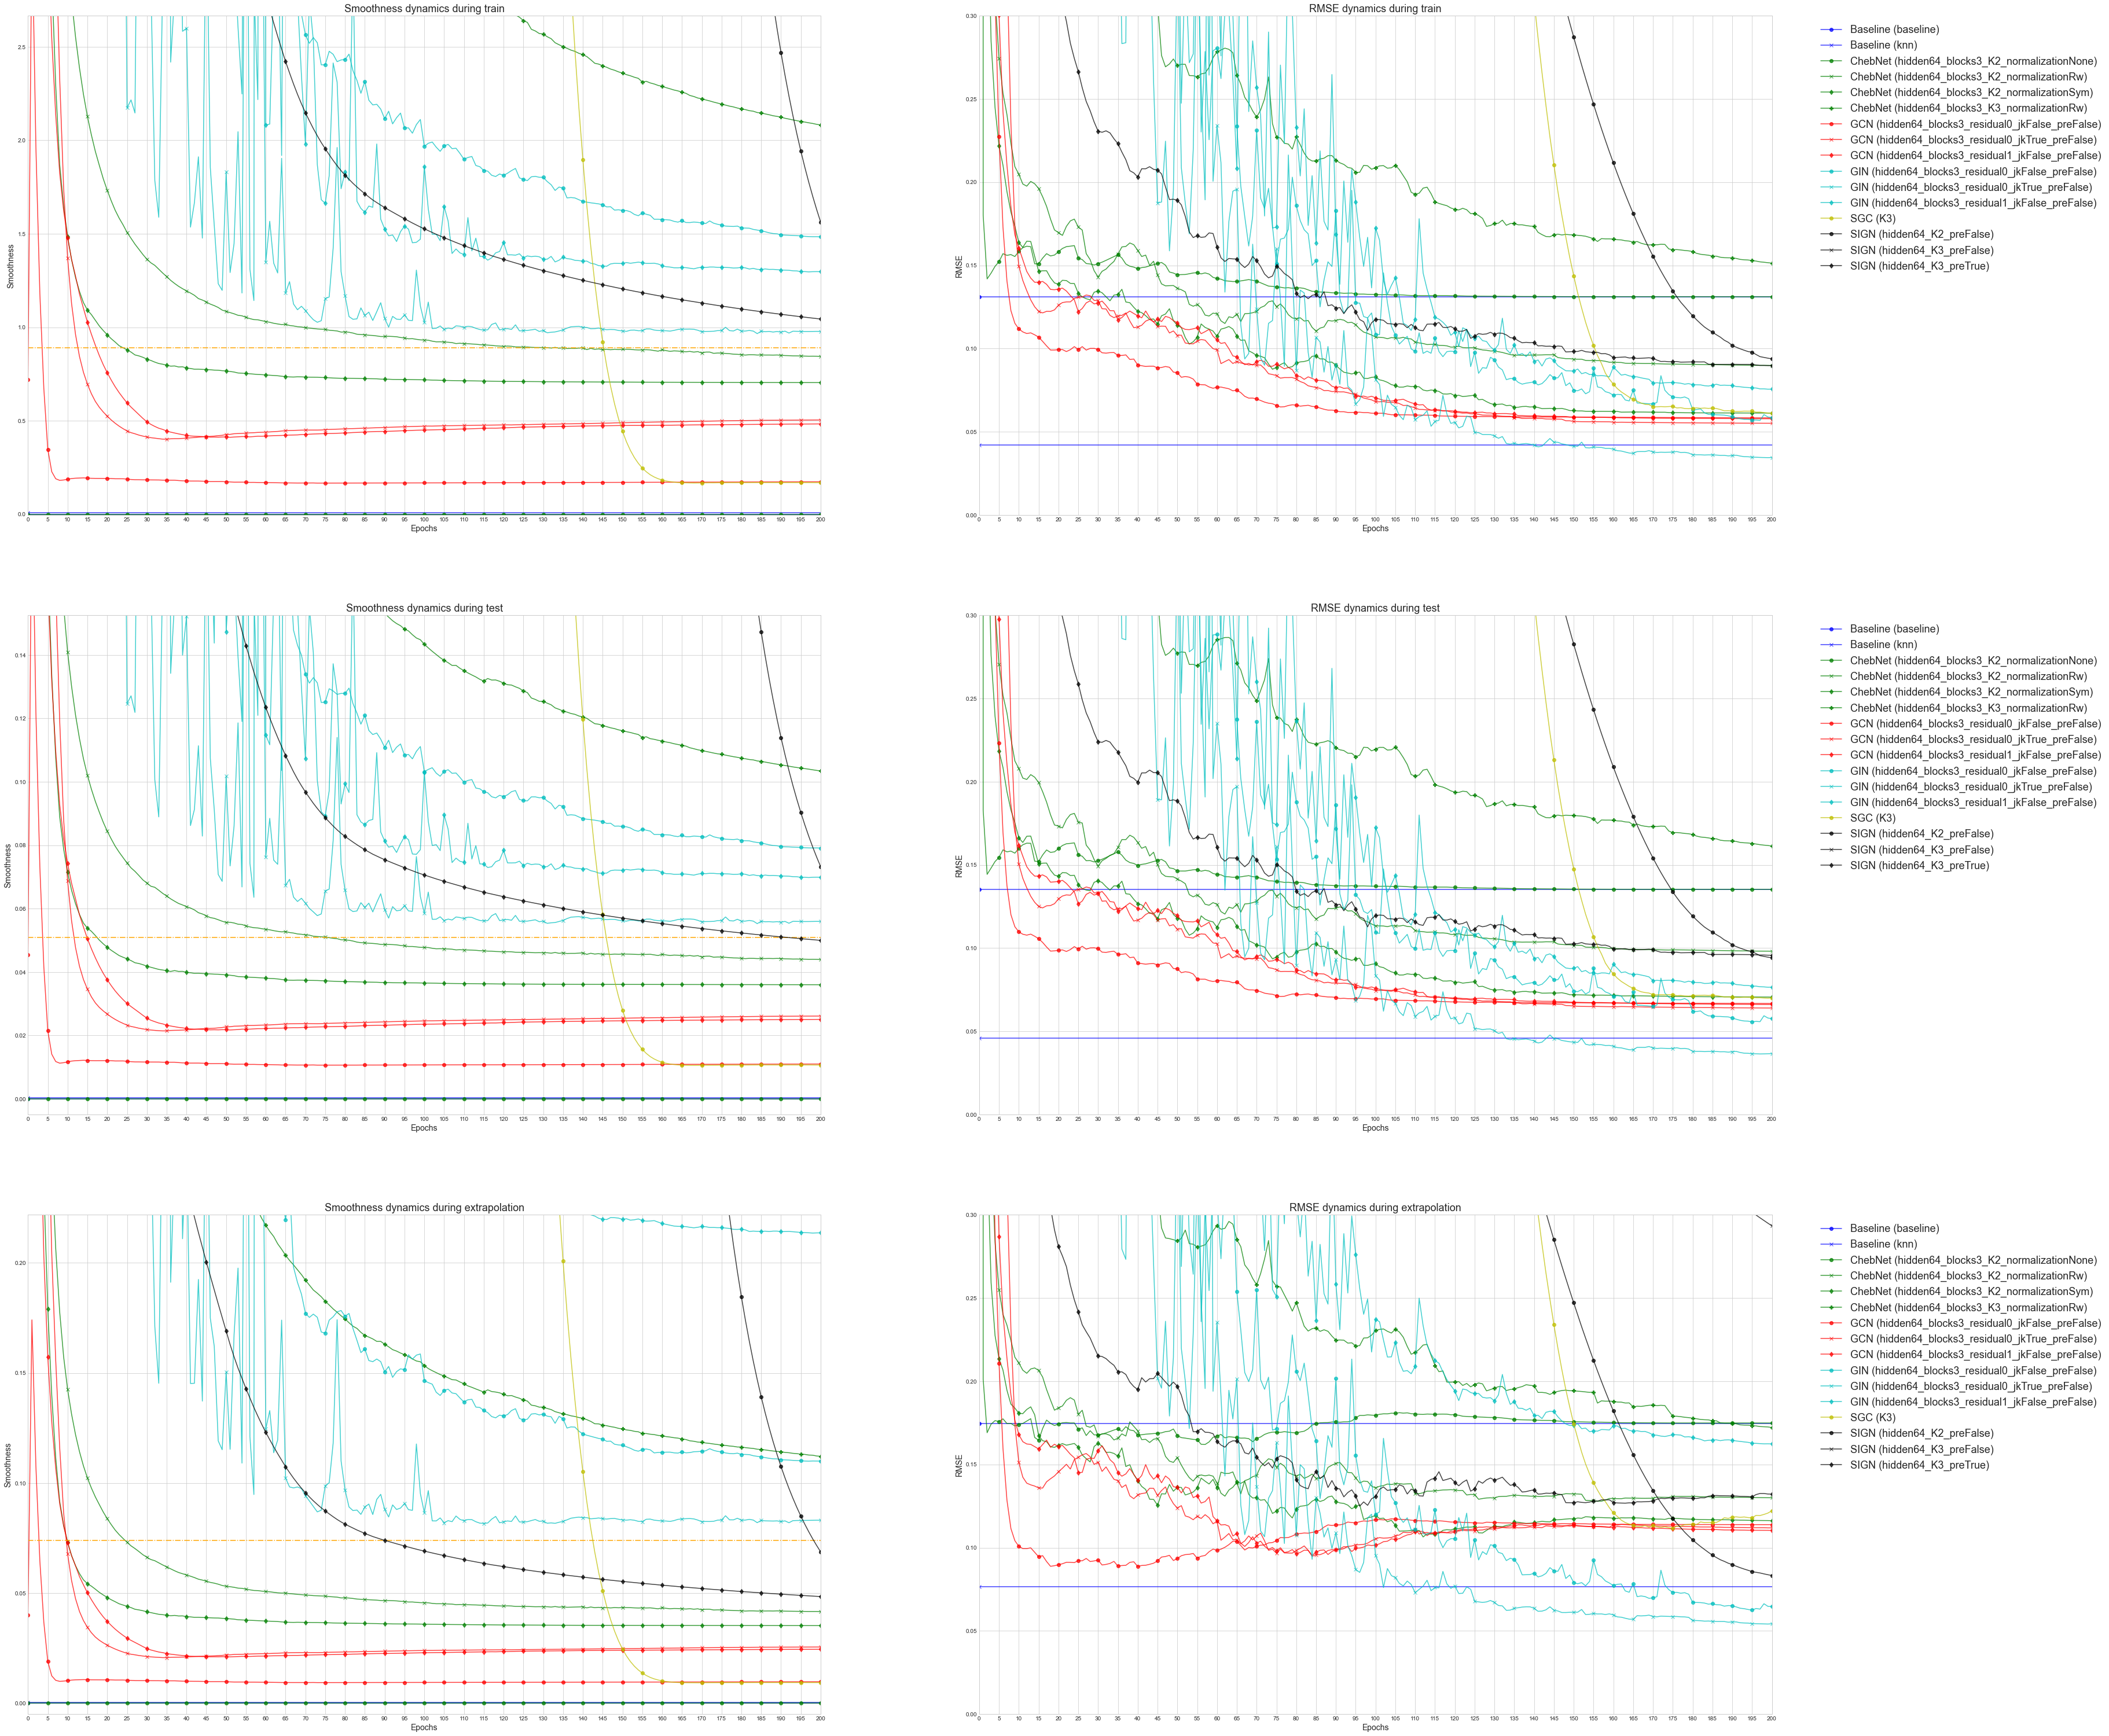

In [60]:

# Retrieve all the column-split data
all_stats_train = getAllStats(smoothness_stats_avg, setting='train')
all_stats_test = getAllStats(smoothness_stats_avg, setting='test')
all_stats_extrapolation = getAllStats(smoothness_stats_avg, setting='extrapolation')
# Retrieve all model parameterizations
model_configs = smoothness_stats_avg.index.tolist()
model_configs_dict = defaultdict(list)
for model_config in model_configs:
    model_configs_dict[model_config[0]].append(model_config[1])
# Define color maps and markers for the models
cmaps = 'bgrcmyk'
markers = 'oxdP1234'

SMOOTHNESS_YLIM_TRAIN=None
SMOOTHNESS_YLIM_TEST=None
SMOOTHNESS_YLIM_EXTRAPOLATION=None
RMSE_YLIM=0.3

# Create the figure and plot everything
fig, ax = plt.subplots(3, 2, figsize=(54, 54))
ax = ax.flatten()

# Train / test /extrapolation
for i, (model, configs) in enumerate(model_configs_dict.items()):
    color = cmaps[i]
    j = 0
    for config in configs: 
        model_config = (model, config)
        # Real signal
        if config == ' ':
            real_smoothness_train = all_stats_train['mean_smoothness'].loc[model_config].to_numpy()[0]
            SMOOTHNESS_YLIM_TRAIN =  3 * real_smoothness_train
            plotDynamicsSmoothnessRMSE(
                ax, 0, 1, all_stats_train, model_config, 
                setting='train', smoothness_ylim=SMOOTHNESS_YLIM_TRAIN, rmse_ylim=RMSE_YLIM)
            real_smoothness_test = all_stats_test['mean_smoothness'].loc[model_config].to_numpy()[0]
            SMOOTHNESS_YLIM_TEST =  3 * real_smoothness_test
            plotDynamicsSmoothnessRMSE(
                ax, 2, 3, all_stats_test, model_config,
                setting='test', smoothness_ylim=SMOOTHNESS_YLIM_TEST, rmse_ylim=RMSE_YLIM)
            real_smoothness_extrapolation = all_stats_extrapolation['mean_smoothness'].loc[model_config].to_numpy()[0]
            SMOOTHNESS_YLIM_EXTRAPOLATION =  3 * real_smoothness_extrapolation
            plotDynamicsSmoothnessRMSE(
                ax, 4, 5, all_stats_extrapolation, model_config,
                setting='extrapolation', smoothness_ylim=SMOOTHNESS_YLIM_EXTRAPOLATION, rmse_ylim=RMSE_YLIM)
        # Baselines & GNNs
        elif ((config.endswith('initDefault_')) or
              (config.startswith('__'.join(DIST_MATRIX.split('__')[:-2])))):
            marker = markers[j]
            j += 1
            plotDynamicsSmoothnessRMSE(
                ax, 0, 1, all_stats_train, model_config, color=color, 
                marker=marker, setting='train', smoothness_ylim=SMOOTHNESS_YLIM_TRAIN, rmse_ylim=RMSE_YLIM)
            plotDynamicsSmoothnessRMSE(
                ax, 2, 3, all_stats_test, model_config, color=color, 
                marker=marker, setting='test', smoothness_ylim=SMOOTHNESS_YLIM_TEST, rmse_ylim=RMSE_YLIM)
            plotDynamicsSmoothnessRMSE(
                ax, 4, 5, all_stats_extrapolation, model_config, color=color, 
                marker=marker, setting='extrapolation', smoothness_ylim=SMOOTHNESS_YLIM_EXTRAPOLATION, rmse_ylim=RMSE_YLIM)
        
# Print some context of the output results        
print_info = f"""
Visualizing smoothness with the following configuration:

    \u2022 Teacher configuration used: \033[4mGIN ({TEACHER_CONFIG})\033[0m.
    \u2022 All student networks were initialized with the same parameters.
    \u2022 Distance matrix used: \033[4m{DIST_MATRIX}\033[0m.


"""
print(print_info)
plt.show()

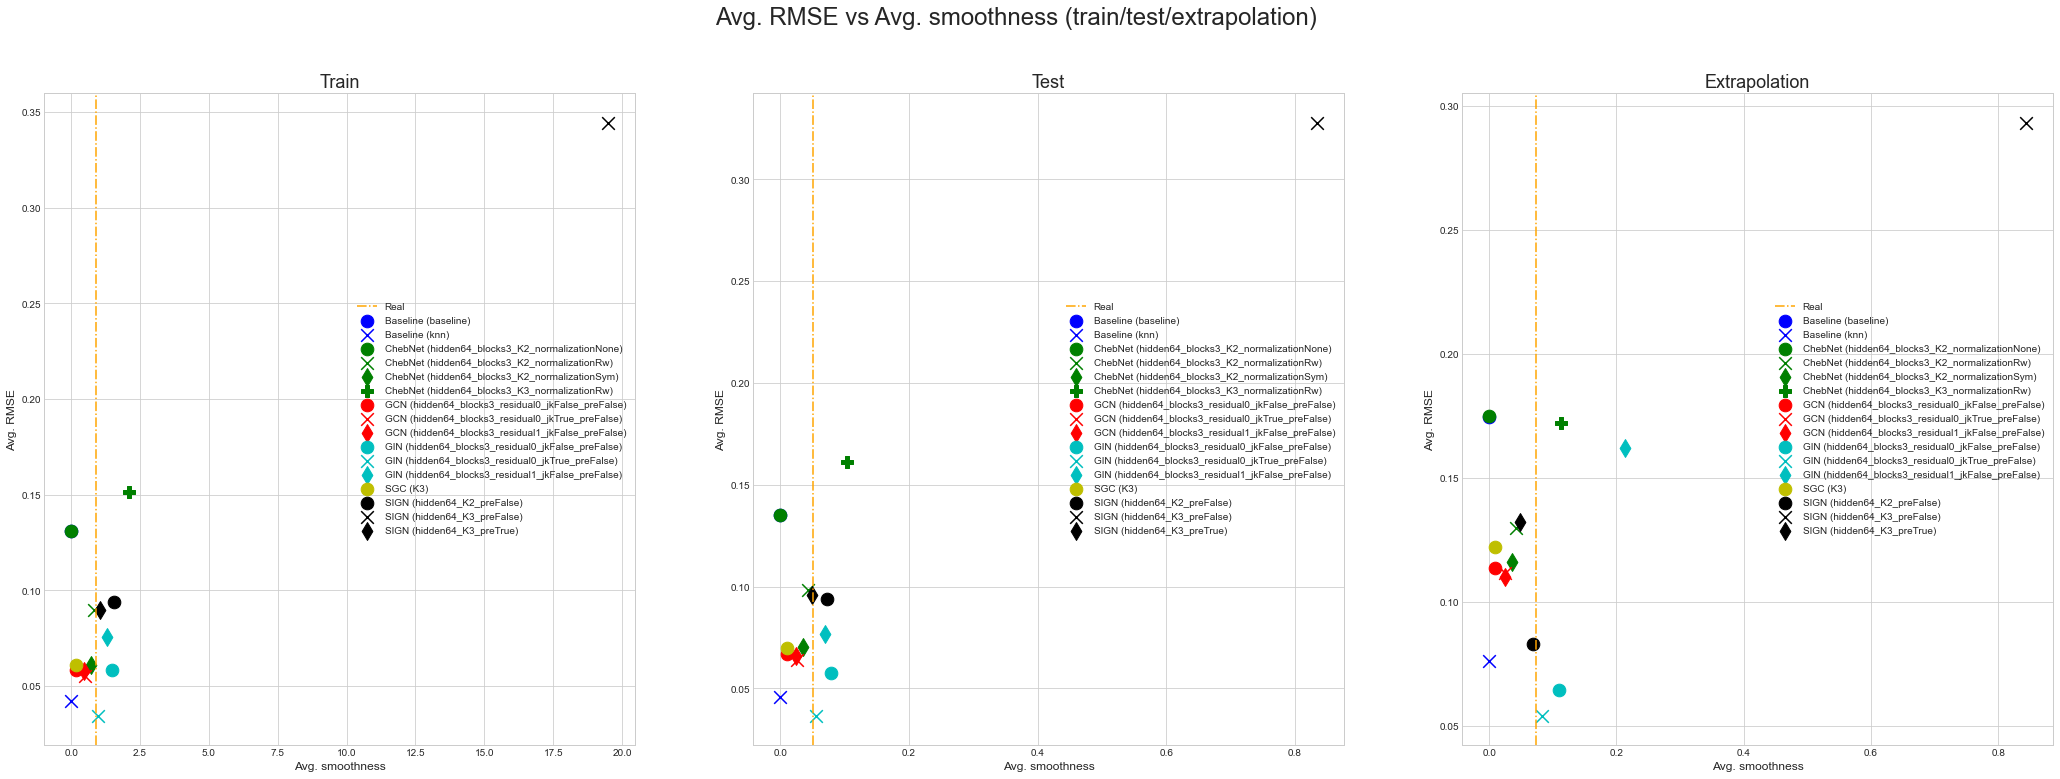

In [63]:
max_epochs = max(list(map(int, smoothness_stats_avg.columns.get_level_values(0).to_numpy())))

baseline_configs = [x for x in smoothness_stats_avg.index.tolist() if x[0] in ['Baseline', 'Real']]
smoothness_stats_avg_final = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(0) == str(max_epochs)]
smoothness_stats_avg_final.columns = smoothness_stats_avg_final.columns.droplevel(0)

# Since the baseline is not trained, substitute with the initial values
for baseline_config in baseline_configs:
    aux = smoothness_stats_avg.loc[baseline_config, smoothness_stats_avg.columns.get_level_values(0) == '0']
    aux.index = aux.index.droplevel(0)
    smoothness_stats_avg_final.loc[baseline_config] = aux
    
# Retrieve all model parameterizations
model_configs_final = smoothness_stats_avg_final.index.tolist()
model_configs_final_dict = defaultdict(list)
for model_config in model_configs_final:
    model_configs_final_dict[model_config[0]].append(model_config[1])

plotScatterSmoothnessRMSE(model_configs_final_dict)